In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gudhi
import gudhi as gd
from utilsTopology import *
from utilsBaricentricNeuralNetwork import *
from utils import *
fontsize=16

# Computations on simplicial complex. Two examples: One consisting of 3 points and another one consisting of 250 points simulating the sine function

Persistence diagram: tf.Tensor(
[[-0.5440211   0.99974334]
 [-0.99974334  0.9999076 ]
 [-0.9999076   0.99998975]
 [-0.99998975  0.99998975]], shape=(4, 2), dtype=float32)
Persistent entropy:  tf.Tensor(1.3805639, shape=(), dtype=float32)


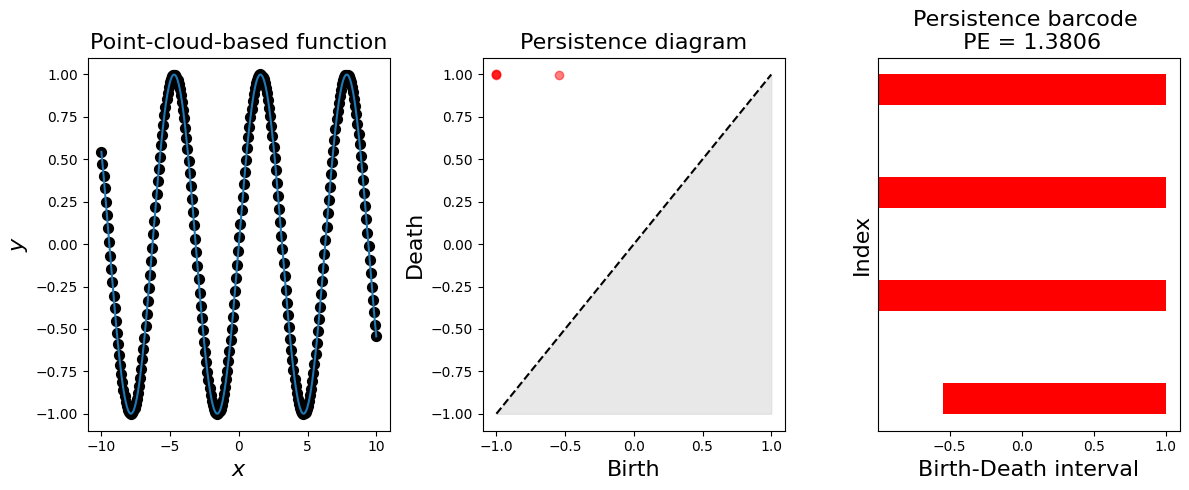

In [11]:
domain =[-10,10]
function=np.sin
num_points=250
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

stbase = gd.SimplexTree()
for i in range(250-1):
    stbase.insert([i,i+1], -1e10) # here we define that each element is connected to the next one, since what we have is a line formed by the points of the point cloud
layer = LowerStarLayer(simplextree=stbase)
dgms = layer.call(tf.Variable(y_train))
dgmRef = dgms[0][0]
print("Persistence diagram:", dgmRef)

dgmsNumpy = dgmRef.numpy()
entropy=persistent_entropy(dgmRef)
print("Persistent entropy: " ,entropy)

plt.figure(figsize=(12, 5))

# Subplot 1: Point cloud
plt.subplot(1, 3, 1)
plt.scatter(x_train, y_train, c='black', s=50, zorder=2)
plt.plot(x_train,y_train)
plt.title('Point-cloud-based function', fontsize=fontsize)
plt.xlabel("$x$", fontsize=fontsize)
plt.ylabel("$y$", fontsize=fontsize)

# Subplot 2: Persistence diagram
plt.subplot(1, 3, 2)
plt.title("Persistence diagram", fontsize=fontsize)
plt.scatter(dgmsNumpy[:, 0], dgmsNumpy[:, 1], color="red", label="0", alpha=0.5)
min_val = min(np.min(dgmsNumpy[:, 0]), np.min(dgmsNumpy[:, 1]))
max_val = max(np.max(dgmsNumpy[:, 0]), np.max(dgmsNumpy[:, 1]))
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
x_vals = np.linspace(min_val, max_val, 100)  # Puntos para la diagonal
plt.fill_between(x_vals, min_val, x_vals, color='lightgray', alpha=0.5)
plt.xlabel("Birth", fontsize=fontsize)
plt.ylabel("Death", fontsize=fontsize)

# Subplot 3: Persistence barcode and persistent entropy
plt.subplot(1, 3, 3)
plt.title(f"Persistence barcode \n PE = {round(float(entropy.numpy()),4)}", fontsize=fontsize)

bar_width = 0.3  
for i, (birth, death) in enumerate(dgmsNumpy):
    plt.barh(i, death - birth, left=birth, color="red", height=bar_width, label="0" if i == 0 else "")

plt.xlabel("Birth-Death interval",fontsize=fontsize)
plt.ylabel("Index",fontsize=fontsize)
plt.yticks([])  

plt.tight_layout()
plt.savefig('figures/DiagramBarcodeExample.png', dpi=300, bbox_inches='tight')
plt.show()



# Persistence barcode with and without noise

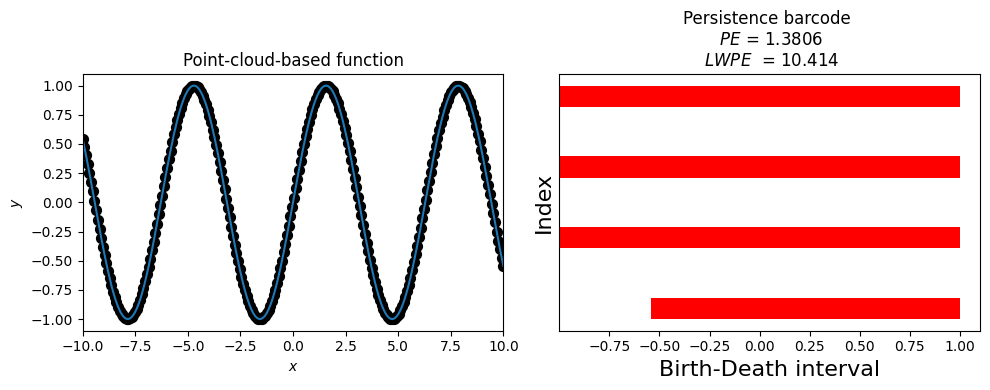

In [8]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

stbase = gd.SimplexTree()
for i in range(250-1):
    stbase.insert([i,i+1], -1e10) # here we define that each element is connected to the next one, since what we have is a line formed by the points of the point cloud
layer = LowerStarLayer(simplextree=stbase)
dgms = layer.call(tf.Variable(y_train))
dgmRef = dgms[0][0]

PERef=persistent_entropy(dgmRef)
LWPERef=length_weighted_persistent_entropy(dgmRef)

num_points_optimize=8
x_points = tf.Variable(tf.cast(tf.linspace(domain[0],domain[1],num_points_optimize), dtype=tf.float32) ,trainable=True)
y_points = interpolation_tf(x_train,y_train, x_points)
points = tf.stack([x_points, y_points], axis=1)

model = BaricentricNetwork(points)

y_aprox = model(tf.expand_dims(x_train,axis=1))

dgmsAprox = layer.call(y_aprox)
dgmAprox = dgmsAprox[0][0]
PEAprox=persistent_entropy(dgmAprox)
LWPEAproxLim=length_weighted_persistent_entropy(dgmAprox)

lossPE = PersistentEntropyLoss()
lossLWPE = LengthWeightedPersistentEntropyLoss()
errorPE = lossPE(dgmRef,dgmAprox)
errorLWPE = lossLWPE(dgmRef,dgmAprox)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].scatter(x_train, y_train, c='black', s=50, zorder=2)
axs[0].plot(x_train,y_train)
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Point-cloud-based function')
axs[1].set_title(f"Persistence barcode")

bar_width = 0.3  
for i, (birth, death) in enumerate(dgmRef):
    axs[1].barh(i, death - birth, left=birth, color="red", height=bar_width, label="0" if i == 0 else "")

axs[1].set_xlabel("Birth-Death interval",fontsize=fontsize)
axs[1].set_ylabel("Index",fontsize=fontsize)
axs[1].set_yticks([])  
axs[1].set_title(axs[1].get_title() + f" \n $PE$ = {round(PERef.numpy().item(),4)}")
axs[1].set_title(axs[1].get_title() + " \n $LWPE$ " + f" = {round(LWPERef.numpy().item(),4)}")
fig.tight_layout()
plt.savefig('figures/WithoutNoiseUnknownFunctionPEVariantsBarcode.png', dpi=300, bbox_inches='tight')
plt.show()

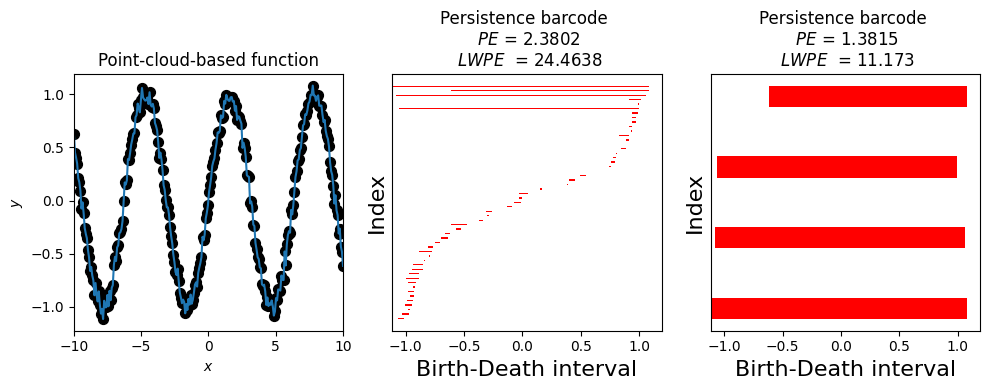

In [10]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
np.random.seed(7)
ruido = np.random.normal(0, 0.05, size=x_train.shape)
y_train = y_train + ruido
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

stbase = gd.SimplexTree()
for i in range(250-1):
    stbase.insert([i,i+1], -1e10) # here we define that each element is connected to the next one, since what we have is a line formed by the points of the point cloud
layer = LowerStarLayer(simplextree=stbase)
dgms = layer.call(tf.Variable(y_train))
dgmRef = dgms[0][0]

PERef=persistent_entropy(dgmRef)
LWPERef=length_weighted_persistent_entropy(dgmRef)

distances = tf.abs(dgmRef[:, 0] - dgmRef[:, 1])  # (n,)
top_x_indices = tf.argsort(distances, direction='DESCENDING')[:int(num_points_optimize/2)]
dgmRefFilt = tf.gather(dgmRef, top_x_indices)
PERefFilt=persistent_entropy(dgmRefFilt)
LWPERefFilt=length_weighted_persistent_entropy(dgmRefFilt)

num_points_optimize=8
x_points = tf.Variable(tf.cast(tf.linspace(domain[0],domain[1],num_points_optimize), dtype=tf.float32) ,trainable=True)
y_points = interpolation_tf(x_train,y_train, x_points)
points = tf.stack([x_points, y_points], axis=1)

model = BaricentricNetwork(points)

y_aprox = model(tf.expand_dims(x_train,axis=1))

dgmsAprox = layer.call(y_aprox)
dgmAprox = dgmsAprox[0][0]
PEAprox=persistent_entropy(dgmAprox)
LWPEAproxLim=length_weighted_persistent_entropy(dgmAprox)

lossPE = PersistentEntropyLoss()
lossLWPE = LengthWeightedPersistentEntropyLoss()
errorPE = lossPE(dgmRef,dgmAprox)
errorLWPE = lossLWPE(dgmRef,dgmAprox)

fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].scatter(x_train, y_train, c='black', s=50, zorder=2)
axs[0].plot(x_train,y_train)
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Point-cloud-based function')
axs[1].set_title(f"Persistence barcode")

bar_width = 0.3  
for i, (birth, death) in enumerate(dgmRef):
    axs[1].barh(i, death - birth, left=birth, color="red", height=bar_width, label="0" if i == 0 else "")

axs[1].set_xlabel("Birth-Death interval",fontsize=fontsize)
axs[1].set_ylabel("Index",fontsize=fontsize)
axs[1].set_yticks([])  
axs[1].set_title(axs[1].get_title() + f" \n $PE$ = {round(PERef.numpy().item(),4)}")
axs[1].set_title(axs[1].get_title() + " \n $LWPE$ " + f" = {round(LWPERef.numpy().item(),4)}")
axs[2].set_title(f"Persistence barcode")

bar_width = 0.3  
for i, (birth, death) in enumerate(dgmRefFilt):
    axs[2].barh(i, death - birth, left=birth, color="red", height=bar_width, label="0" if i == 0 else "")

axs[2].set_xlabel("Birth-Death interval",fontsize=fontsize)
axs[2].set_ylabel("Index",fontsize=fontsize)
axs[2].set_yticks([])  
axs[2].set_title(axs[2].get_title() + f" \n $PE$ = {round(PERefFilt.numpy().item(),4)}")
axs[2].set_title(axs[2].get_title() + " \n $LWPE$ " + f" = {round(LWPERefFilt.numpy().item(),4)}")
fig.tight_layout()
plt.savefig('figures/WithNoiseUnknownFunctionPEVariantsBarcode.png', dpi=300, bbox_inches='tight')
plt.show()